![MAIA banner](https://raw.githubusercontent.com/MAIA4361-Aprendizaje-refuerzo-profundo/Notebooks_Tareas/main/Images/Aprendizaje_refuerzo_profundo_Banner_V1.png)

# <h1><center>Tarea Tutorial - Semana 7</center></h1>

<center><h1>DDPG y TD3</h1></center>

Este tutorial sigue con el estudio de algoritmos de gradiente de política. Concretamente, se revisarán 2 algoritmos: Deep Deterministic Policy Gradient (DDPG) y Twin Delayed Deep Deterministic Policy Gradient (TD3). Se utilizará la implementación de ambos algoritmos encontrada dentro de <a href="https://stable-baselines3.readthedocs.io/en/master/index.html">Stable Baselines3</a>, y los usaremos para resolver problemas de robótica basados en el entorno de simulación MuJoCo: <a href="https://gymnasium.farama.org/v0.28.1/environments/mujoco/reacher/">Reacher</a>, <a href="https://gymnasium.farama.org/environments/mujoco/ant/">Ant</a> y <a href="https://gymnasium.farama.org/v0.28.1/environments/mujoco/half_cheetah/">Half Cheetah</a>. Este notebook tutorial se divide en las siguientes secciones:


# Tabla de Contenidos
1. [Objetivos de Aprendizaje](#scrollTo=Objetivos_de_Aprendizaje)  
2. [Marco Teórico](#scrollTo=Marco_Te_rico)  
3. [Instalación de Librerías](#scrollTo=Instalaci_n_de_Librer_as)  
4. [Familiarización con los Entornos de Gym](#scrollTo=Familiarizaci_n_con_los_Entornos_de_Gym)
5. [Entrenamiento de agentes DDPG y TD3 para Reacher](#scrollTo=Entrenamiento_de_agentes_DDPG_y_TD3_para_Reacher)
6. [Entrenamiento de agentes DDPG y TD3 para Ant](#scrollTo=Entrenamiento_de_agentes_DDPG_y_TD3_para_Ant)
7. [Entrenamiento de agentes DDPG y TD3 para Half Cheetah](#scrollTo=Entrenamiento_de_agentes_DDPG_y_TD3_para_Half_Cheetah)
8. [Reflexiones Finales](#scrollTo=Reflexiones_Finales)  
9. [Referencias](#scrollTo=Referencias)

# Objetivos de Aprendizaje  
  
* Comprender las bases teóricas detrás de algoritmos actor-crítico para problemas de control continuo.
* Solucionar problemas de robótica basados en simulaciones físicas usando los algoritmos de DDPG y TD3.
* Comparar las ventajas y desventajas que existen entre DDPG y TD3.

# Marco Teórico  



Previamente, se ha estudiado el algoritmo de Deep Q-Networks (DQN). Un algoritmo <i>off-policy</i> que fue novedoso al integrar la aproximación de funciones en el Aprendizaje por Refuerzo. No obstante, este algoritmo presenta problemas para ambientes con acciones continuas, ya que el algoritmo de DQN solo funciona en ambientes con acciones discretas, y únicamente suele obtener buenos resultados cuando este espacio de acciones es reducido. En la vida real hay muchas tareas de control que involucran espacios de acciones continuas y de alta dimensionalidad. Adaptar DQN a estos casos de acciones continuas no es sencillo, ya que como este algoritmo depende de maximizar la función $Q(s,a)$, en el caso continuo se requeriría un proceso iterativo en cada paso. Y por otro lado, aunque una alternativa sea discretizar el espacio de acciones, esto rápidamente hace crecer las alternativas de acción y el algoritmo se vuelve ineficiente. [1]

Para solucionar estos problemas se propuso el algoritmo Deep Deterministic Policy Gradient (DDPG). DDPG es un algoritmo que sigue el esquema actor-crítico, de carácter <i>off-policy</i> y <i>model-free</i>, capaz de aprender políticas útiles en ambientes con grandes espacios de acciones continuas. Este algoritmo se construye sobre otro algoritmo conocido como Deterministic Policy Gradient (DPG), pero incorpora, como hizo DQN, una forma estable de incorporar la aproximación de funciones. [1]

DDPG mantiene en el actor una función parametrizada $\mu(s,\theta^\mu)$, que especifica la política actual mapeando determinísticamente los estados a una acción específica. Mientras, el crítico aprende la función $Q(s,a)$ usando la Ecuación de Bellman como en Q-learning. Se actualiza al actor utilizando el método de gradiente de política sobre el vector de parámetros $\theta$. [1]

DDPG, similar a DQN, aplica técnicas para mantener convergencia y estabilidad a pesar de utilizar funciones no lineales mediante la aproximación con redes neuronales. Algunas de estas técnicas incluyen el uso de <i>mini-batches</i>,  un <i>buffer replay</i> y <i>batch normalization</i>. Todas estas estrategias ayudan a las redes neuronales a estabilizar el entrenamiento, mejorar la eficiencia de muestreo y reducir la correlación entre observaciones consecutivas. Otra modificación importante que hace DDPG para hacer un aprendizaje <i>off-policy</i> es realizar copias de los pesos de las redes del actor y el crítico, y los pesos de las redes objetivo se actualiza haciendo un seguimiento de las redes de comportamiento, haciendo que los valores objetivo se restrinjan a cambiar lentamente, mejorando así la estabilidad de entrenamiento. Finalmente, para mejorar la exploración, se añade ruido a la política de exploración, generalmente a partir de una distribución normal. [1]

Por otro lado, en DQN también aparecía un problema de sesgo de maximización, que podía ser corregido o mejorado utilizando el esquema de Doble DQN. De manera similar, el sesgo de maximización también existe en los algoritmos actor-crítico. Sin embargo, este problema no se puede solucionar con la misma estrategia de Doble DQN porque la política en los algoritmos actor-crítico cambia muy lentamente, y por lo cual los valores estimados son muy similares para evitar el sesgo. Una alternativa es utilizar una versión <i>clipped</i> de Doble Q-Learning. Esto, en cambio, puede introducir un sesgo de subestimación, pero es preferible y este sesgo no se propaga por el resto del entrenamiento. [2]

Los métodos actor-crítico a veces fallan en su aprendizaje debido a la divergencia que puede ocurrir por actualizaciones de la política realizadas con estimaciones de valor de alta varianza. En la interacción actor-crítico, las estimaciones de la función de valor divergen por sobreestimación cuando la política es deficiente, y la política se vuelve deficiente si la estimación de valor es inexacta. Para corregir este problema, la red de la política debería ser actualizada con menor frecuencia que la red del crítico, pero primero es necesario minimizar el error antes de introducir la actualización de la política. En el algoritmo TD3 (Twin Delayed Deep Deterministic Policy Gradient) se retrasan las actualizaciones de la política hasta que el error en la función de valor sea lo más pequeño posible. La modificación que incluye este algoritmo consiste en actualizar la política y las redes objetivo únicamente después de un número fijo de actualizaciones del crítico. [2]

Cuando se retrasan lo suficiente las actualizaciones de la política, efectivamente se limita la probabilidad de repetir actualizaciones respecto a un crítico que no ha cambiado. Y aunque se actualice con menor frecuencia la política, la estimación del crítico tendría menos varianza, y por ende las actualizaciones serían de mayor calidad. Adicionalmente, TD3 usa una regularización similar a la de SARSA, que aplica un <i>bootstrapping</i> a partir de estimaciones de acciones similares para reducir aún más la varianza. Esto se logra en la práctica introduciendo una pequeña cantidad de ruido a aleatorio (normal) a la política objetivo. [2]



# Instalación de Librerías  

Con el siguiente bloque de código se instalan las librerías requeridas en el tutorial. Se encuentra incluido el módulo oficial de Stable Baselines3 que ejecuta DDPG y TD3, y los ambientes de Gymnasium de MuJoCo que incluyen Reacher, Ant y Half Cheetah. Esta celda puede tardar un par de minutos en ejecutarse completamente la primera vez.

In [1]:
# Instalación de dependencias del sistema
!apt update -y > /dev/null
!apt install -y xvfb ffmpeg > /dev/null

# Instalación de paquetes de Python (Gymnasium con MuJoCo, Stable Baselines3, y herramientas de video)
!pip install gymnasium[mujoco]
!pip install pyvirtualdisplay
!pip install imageio[ffmpeg]
!pip install stable-baselines3[extra]


# Importación de librerías necesarias

# Librerías para mostrar video
from pyvirtualdisplay import Display
from IPython.display import HTML
from base64 import b64encode
# Librerías básicas
import os
import gymnasium as gym
import imageio
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
import time
# Stable Baselines3 y herramientas
from stable_baselines3 import DDPG
from stable_baselines3 import TD3
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.noise import NormalActionNoise #Función para incorporar ruido

#Limpia los registros generados
from IPython.display import clear_output
clear_output()
print("Todas las librerías han sido instaladas correctamente.")

Todas las librerías han sido instaladas correctamente.


# Familiarización con los Entornos de Gym

Los siguientes ambientes de Gymnasium son entornos basados en MuJoCo de Google Deep Mind. MuJoCo (Multi-Joint dynamics with Contact) es un simulador físico utilizado para modelar y estudiar el comportamiento de sistemas dinámicos complejos, muy utilizado en robótica.


## Reacher

El ambiente de <a href="https://gymnasium.farama.org/environments/mujoco/reacher/">Reacher</a> es uno de los ambientes más sencillos de MuJoCo. Consiste en un brazo robótico horizontal de dos eslabones, y el objetivo es que la punta del brazo (efecto final) se mueva cerca de un objetivo que aparece en una posición aleatoria.

![Action_space_reacher](https://raw.githubusercontent.com/MAIA4361-Aprendizaje-refuerzo-profundo/Notebooks_Tareas/main/Images/Action_space_reacher.png)

<center>Figura 1. Descripción del ambiente de Reacher. [3]</center>

En Reacher hay dos uniones de bisagra, una en la base del primer eslabón y otra en la intersección de los dos eslabones. El espacio de acciones corresponde al torque aplicado en estas dos uniones, como muestra la Figura 1. Por otro lado, el espacio de observaciones consiste en 11 valores, entre los que se encuentran algunos valores de senos y cosenos de los ángulos formados por el brazo y su velocidad angular, sumado a las coordenadas de posición del objetivo y del efector final del brazo.

La recompensa es calculada simplemente como una medida de la distancia entre la punta del brazo y el objetivo, con una penalización por acciones (torques) muy grandes.

## Ant

El ambiente de <a href="https://gymnasium.farama.org/environments/mujoco/ant/">Ant</a> consiste en un robot cuadrúpedo formado por un torso con forma esférica y cuatro piernas con 2 partes cada una. En total el robot cuenta con 8 motores, y el objetivo de esta "hormiga" es moverse hacia adelante (dirección derecha de la simulación).

![Action_space_ant](https://raw.githubusercontent.com/MAIA4361-Aprendizaje-refuerzo-profundo/Notebooks_Tareas/main/Images/Action_space_ant.png)

<center>Figura 2. Descripción del ambiente de Ant. [4]</center>

En Ant el espacio de acciones está dado por el control de torque entre -1 y 1 de los 8 motores del sistema dinámico de acuerdo con los índices de la Figura 2. En este caso, el espacio de observación está descrito por 13 posiciones (<i>qpos</i>) y 14 velocidades (<i>qvel</i>) de las partes del robot, y 78 elementos adicionales relacionados con el centro de masa y fuerzas externas al sistema.

La recompensa es calculada ponderando 4 aspectos. En Ant se le da una recompensa en cada timestep por conservar la estabilidad y se recompensa que el robot avance en la dirección deseada. También se penalizan acciones muy grandes. El cuarto elemento involucrado en este ambiente corresponde a un castigo si las fuerzas de contacto externas son demasiado grandes.

## Half Cheetah

El ambiente de <a href="https://gymnasium.farama.org/environments/mujoco/half_cheetah/">Half Cheetah</a> consiste en un robot de dos dimensiones con forma de cheetah. El robot de dos patas tiene en total 9 barras y 8 uniones, y el objetivo es que el animal corra hacia adelante (dirección derecha de la simulación) lo más rápido posible.

![Action_space_cheetah](https://raw.githubusercontent.com/MAIA4361-Aprendizaje-refuerzo-profundo/Notebooks_Tareas/main/Images/Action_space_cheetah.png)

<center>Figura 3. Descripción del ambiente de Half Cheetah. [5]</center>

En Half Cheetah el espacio de acciones corresponde al torque aplicado en 6 motores, correspondientes al muslo, espinilla y pie trasero y delantero, de acuerdo con los índices de la Figura 1. El espacio de observación está compuesto en total por 17 valores, que incluyen múltiples posiciones angulares, velocidades, velocidades angulares, y la posición en el eje horizontal de la cadera frontal.

La recompensa es calculada teniendo en cuenta dos aspectos. Primero, una recompensa por moverse hacia adelante, la cual se hace más grande en cuanto menor tiempo utilice para desplazarse la mayor cantidad de distancia, y positiva si se mueve hacia la derecha. En segundo lugar, una penalización si las acciones (torques) son muy grandes.

# Entrenamiento de agentes DDPG y TD3 para Reacher

En este notebook tutorial, se busca aplicar los algoritmos de DDPG y TD3 para los 3 problemas anteriormente mostrados. Primero, se va a exponer cómo se puede entrenar a los agentes para Reacher. Para ello, se utiliza la clase <i>MujocoTrainer</i>, incluida a continuación.

In [2]:
# Clase personalizada para registrar las recompensas por episodio durante el entrenamiento
class RewardLoggerCallback(BaseCallback):
    def __init__(self):
        super().__init__()
        self.episode_rewards = []  # Lista para almacenar las recompensas por episodio
        self.episode_reward = 0    # Acumulador de recompensa para el episodio actual

    def _on_step(self) -> bool:
        # Si hay recompensas disponibles en el paso actual, se suman al acumulador
        if "rewards" in self.locals:
            self.episode_reward += self.locals["rewards"][0]
        # Si el episodio ha terminado, se guarda la recompensa acumulada y se reinicia el contador
        if "dones" in self.locals and self.locals["dones"][0]:
            self.episode_rewards.append(self.episode_reward)
            self.episode_reward = 0
        return True


# Clase para entrenar un agente en el entorno Hopper
class MujocoTrainer:
    def __init__(self, model_fn,  env_name, total_timesteps=100_000, log_dir="./logs"):
        self.total_timesteps = total_timesteps
        self.env_name=env_name
        self.log_dir = log_dir
        os.makedirs(log_dir, exist_ok=True)  # Crear el directorio de logs si no existe

        # Iniciar una pantalla virtual (necesaria en Colab o entornos sin interfaz gráfica)
        self.display = Display(visible=0, size=(1400, 900))
        self.display.start()

        # Crear el entorno Hopper vectorizado
        self.env = make_vec_env(self.env_name, n_envs=1)

        # Crear el modelo usando la función proporcionada
        self.model = model_fn(self.env)

        # Inicializar el callback para registrar recompensas
        self.callback = RewardLoggerCallback()


    def train(self, save_path="path"):
        print("GPU available?", torch.cuda.is_available())
        if torch.cuda.is_available():
            print("Using device:", torch.cuda.get_device_name(0))

        start_time = time.time()
        # Entrenar el modelo con el número total de pasos y el callback
        self.model.learn(total_timesteps=self.total_timesteps, log_interval=50, callback=self.callback)
        elapsed = time.time() - start_time

        # Guardar el modelo entrenado
        self.model.save(save_path)
        print(f"Training complete. Model saved. Training took {elapsed:.2f} seconds.")

    def plot_rewards(self):
        # Verificar si hay datos de recompensa para graficar
        if not self.callback.episode_rewards:
            print("No reward data to plot.")
            return
        # Graficar las recompensas por episodio
        plt.figure(figsize=(10, 5))
        plt.plot(self.callback.episode_rewards, label="Episode Reward")
        plt.xlabel("Episodes")
        plt.ylabel("Reward")
        plt.title("Training Rewards Over Time")
        plt.grid()
        plt.legend()
        plt.tight_layout()
        plt.show()

    def generate_video(self, model, video_filename="video.mp4"):
        # Crear entorno Hopper con renderizado RGB
        env = gym.make(self.env_name, render_mode="rgb_array")
        obs, info = env.reset()
        frames = []
        total_reward = 0
        terminated = truncated = False

        # Ejecutar el entorno hasta que termine
        while not (terminated or truncated):
            action, _ = model.predict(obs, deterministic=True)  # Predecir acción
            obs, reward, terminated, truncated, info = env.step(action)
            frame = env.render()  # Capturar fotograma
            frames.append(frame)
            total_reward += reward

        env.close()

        # Guardar el video como archivo MP4
        imageio.mimsave(video_filename, frames, fps=30)
        print("Total reward:", total_reward)

        # Mostrar el video en Colab
        mp4 = open(video_filename, "rb").read()
        data_url = "data:video/mp4;base64," + b64encode(mp4).decode()

        return HTML(f"""
        <video width=600 controls>
            <source src="{data_url}" type="video/mp4">
        </video>
        """)


Este clase ya incluye las funciones necesarias para realizar el entrenamiento, graficar las curvas de aprendizaje y generar el video de la política resultante. Requiere como argumentos el nombre del ambiente a utilizar (en este caso `Reacher-v4`), la función del algoritmo, la cantidad de pasos de entrenamiento, y otras especificaciones para el nombre del modelo y el video que se guardan temporalmente en los archivos de Colab.

A continuación también se encuentra la definición con las funciones de ambos algoritmos con los hiperparámetros por defecto de manera explícita:

In [ ]:
def create_model_ddpg(env):
    return DDPG(
        "MlpPolicy",
        env,
        learning_rate=0.001,
        buffer_size=40000, #Este parámetro ha sido ajustado a la memoria disponible en Colab
        learning_starts=100,
        batch_size=256,
        tau=0.005,
        gamma=0.99,
        train_freq=1,
        gradient_steps=1,
        action_noise=None,
        verbose=1
    )

def create_model_td3(env):
    return TD3(
        "MlpPolicy",
        env,
        learning_rate=0.001,
        buffer_size=1000000,
        learning_starts=100,
        batch_size=256,
        tau=0.005,
        gamma=0.99,
        train_freq=1,
        gradient_steps=1,
        action_noise=None,
        policy_delay=2,
        target_policy_noise=0.2,
        target_noise_clip=0.5,
        stats_window_size=100,
        verbose=1
    )

En los siguientes bloques de código, se muestra el entrenamiento obtenido con DDPG y TD3 utilizando la configuración por defecto.

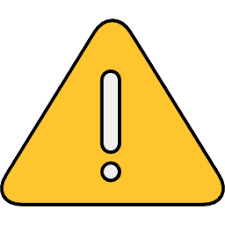 <i>En la práctica DDPG y TD3 toman más tiempo de entrenamiento que otros algoritmos. Los entrenamientos pueden tomar entre 40 y 60 minutos con los 100,000 timesteps sugeridos.</i>

  logger.deprecation(



Using cpu device
GPU available? False
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50       |
|    ep_rew_mean     | -16.4    |
| time/              |          |
|    episodes        | 50       |
|    fps             | 38       |
|    time_elapsed    | 64       |
|    total_timesteps | 2500     |
| train/             |          |
|    actor_loss      | 2.94     |
|    critic_loss     | 0.00196  |
|    learning_rate   | 0.001    |
|    n_updates       | 2399     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50       |
|    ep_rew_mean     | -12.4    |
| time/              |          |
|    episodes        | 100      |
|    fps             | 37       |
|    time_elapsed    | 132      |
|    total_timesteps | 5000     |
| train/             |          |
|    actor_loss      | 4.22     |
|    critic_loss     | 0.00168  |
|    learning_rate   | 0.001    |
|    n_upd

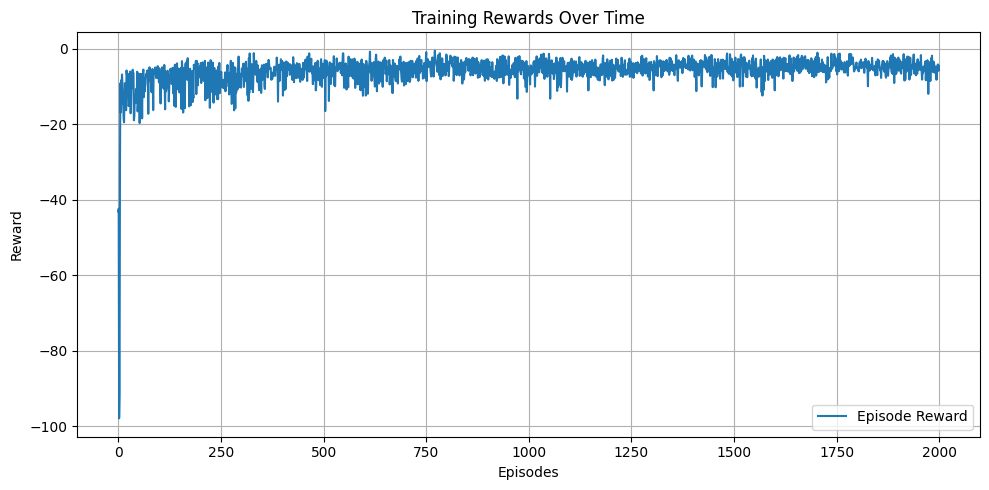

Total reward: -6.913559204041977


In [ ]:
# Entrenamiento de DDPG en Reacher

trainer3 = MujocoTrainer(model_fn=create_model_ddpg,env_name="Reacher-v4",total_timesteps=100_000) #Se crea el agente DDPG y se va a entrenar por 100,000 pasos
trainer3.train(save_path="DDPG_reacher_model") #Se inicia el entrenamiento y se guarda el modelo con el nombre especificado
model3=DDPG.load("DDPG_reacher_model") #Se carga el modelo (usando el mismo algoritmo de SB3)
trainer3.plot_rewards() #Se grafica la curva de aprendizaje observada en el entrenamiento
trainer3.generate_video(model3, video_filename="DDPG_reacher_video.mp4") #Se genera el video y se guarda con el nombre especificado

  logger.deprecation(



Using cpu device
GPU available? False
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50       |
|    ep_rew_mean     | -14.9    |
| time/              |          |
|    episodes        | 50       |
|    fps             | 39       |
|    time_elapsed    | 62       |
|    total_timesteps | 2500     |
| train/             |          |
|    actor_loss      | 2.17     |
|    critic_loss     | 0.0299   |
|    learning_rate   | 0.001    |
|    n_updates       | 2399     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50       |
|    ep_rew_mean     | -12.3    |
| time/              |          |
|    episodes        | 100      |
|    fps             | 38       |
|    time_elapsed    | 130      |
|    total_timesteps | 5000     |
| train/             |          |
|    actor_loss      | 3.87     |
|    critic_loss     | 0.0314   |
|    learning_rate   | 0.001    |
|    n_upd

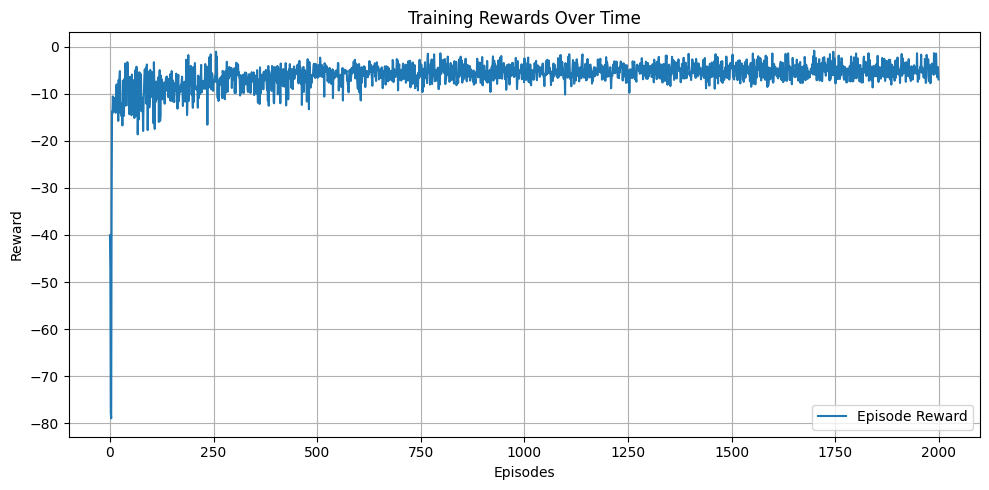

Total reward: -4.376433502500134


In [ ]:
# Entrenamiento de TD3 en Reacher

trainer4 = MujocoTrainer(model_fn=create_model_td3,env_name="Reacher-v4",total_timesteps=100_000) #Se crea el agente DDPG y se va a entrenar por 100,000 pasos
trainer4.train(save_path="TD3_reacher_model") #Se inicia el entrenamiento y se guarda el modelo con el nombre especificado
model4=DDPG.load("TD3_reacher_model") #Se carga el modelo (usando el mismo algoritmo de SB3)
trainer4.plot_rewards() #Se grafica la curva de aprendizaje observada en el entrenamiento
trainer4.generate_video(model4, video_filename="TD3_reacher_video.mp4") #Se genera el video y se guarda con el nombre especificado

En general, ambos algoritmos cumplen de forma satisfactoria con la tarea. En ambos casos, el efector final se acerca al punto objetivo y la curva de aprendizaje muestra una saturación rápida de la recompensa.

# Entrenamiento de agentes DDPG y TD3 para Half Cheetah

Ahora, intente replicar entrenamientos con ambos algoritmos para el problema de Half Cheetah. Puede utilizar la misma clase <i>MujocoTrainer</i>, esta vez pasando como nombre de ambiente `HalfCheetah-v5`. También puede redefinir las funciones de los algoritmos ajustando hiperparámetros, y se recomienda:


*   Ajustar la tasa de aprendizaje.
*   Incorporar un ruido en el espacio de acciones. Para esto puede usar la función `NormalActionNoise` de `stable_baselines3.common.noise`.



In [ ]:
# Entrenamiento de DDPG en Half Cheetah

# =====================================================
# COMPLETAR ===========================================
#

# =====================================================

In [ ]:
# Entrenamiento de TD3 en Half Cheetah

# =====================================================
# COMPLETAR ===========================================
#

# =====================================================

# Entrenamiento de agentes DDPG y TD3 para Ant

Ahora, intente replicar entrenamientos con ambos algoritmos para el problema de Ant. Puede utilizar la misma clase <i>MujocoTrainer</i>, esta vez pasando como nombre de ambiente `Ant-v5`. También puede redefinir las funciones de los algoritmos ajustando hiperparámetros, y se recomienda:


*   Ajustar la tasa de aprendizaje.
*   Incorporar un ruido en el espacio de acciones. Para esto puede usar la función `NormalActionNoise` de `stable_baselines3.common.noise`.

In [ ]:
# Entrenamiento de DDPG en Ant

# =====================================================
# COMPLETAR ===========================================
#

# =====================================================

In [ ]:
# Entrenamiento de TD3 en Ant

# =====================================================
# COMPLETAR ===========================================
#

# =====================================================

# Reflexiones Finales



*   **¿Cómo fue el comportamiento de cada algoritmo en términos de crecimiento de recompensa y varianza durante los entrenamientos?**

*   **¿Qué algoritmo obtuvo mejores resultados? ¿A qué puede deberse?**

*   **¿Qué importancia tiene utilizar un ruido en el espacio de acciones durante el entrenamiento?**






# Referencias

[1] Lillicrap, T. P., Hunt, J. J., Pritzel, A., Heess, N., Erez, T., Tassa, Y., Silver, D., & Wierstra, D. (2016). Continuous Control With Deep Reinforcement Learning. arXiv:1509.02971.

[2] Fujimoto, S., van Hoof, H., & Meger, D. (2018). Addressing Function Approximation Error in Actor-Critic Methods. arXiv:1802.09477.

[3] Gym Documentation, Reacher. `https://gymnasium.farama.org/environments/mujoco/reacher/`

[4] Gym Documentation, Ant. `https://gymnasium.farama.org/environments/mujoco/ant/`

[5] Gym Documentation, Half Cheetah. `https://gymnasium.farama.org/environments/mujoco/half_cheetah/`

[6] Stable Baselines3 Documentation, PPO. `https://stable-baselines3.readthedocs.io/en/master/modules/ddpg.html`

[7] Stable Baselines3 Documentation, PPO. `https://stable-baselines3.readthedocs.io/en/master/modules/td3.html`



